<center><h1>Saliency Ranking (SaRa) Iteration Experiment (COCO)</h1>
<h2>Matthias Bartolo</h2>

</center>

**<h3> Package Imports </h3>**

In [1]:
import cv2
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
import SaRa.saraRC1 as sara
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_img(img):
    plt.figure(figsize=(10,7))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

**<h3>Retrieving COCO information</h3>**

In [3]:
os.getcwd()

'd:\\GitHub\\Final-Year-Project--RL-Vision-\\Experiments\\Threshold Experiments'

In [4]:
generator = 'itti'
GRID_SIZE = 9
THRESHOLD = 0.3

# Define COCO annotation file and data type
coco_version = "2017"  # Choose 2014 or 2017
data_type = "train"  # Choose "train" or "val"
annotation_file = f"../Datasets/COCODataset/annotations/instances_{data_type}{coco_version}.json"

# Load COCO dataset and annotations
coco = COCO(annotation_file)
category_ids = coco.getCatIds()

# Class subset
subset_count = 1000  # Number of images to use for each class subset

loading annotations into memory...
Done (t=8.26s)
creating index...
index created!


In [5]:
category_dict = {}

for category_id in category_ids:
    # Retrieving category name
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']

    category_dict[category_id] = category_name

print(category_dict)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

**<h3> Resisizing Based on the Most Important Ranks from SaRa Function </h3>**

In [6]:
def resize_based_on_important_ranks(img, sara_info, grid_size, rate=0.3):
    def generate_segments(image, seg_count) -> dict:
        """
            Function to generate segments of an image

            Args:
                image: input image
                seg_count: number of segments to generate

            Returns:
                segments: dictionary of segments
        
        """
        # Initializing segments dictionary
        segments = {}
        # Initializing segment index and segment count
        segment_count = seg_count
        index = 0

        # Retrieving image width and height
        h, w = image.shape[:2]

        # Calculating width and height intervals for segments from the segment count
        w_interval = w // segment_count
        h_interval = h // segment_count

        # Iterating through the image and generating segments
        for i in range(segment_count):
            for j in range(segment_count):
                # Calculating segment coordinates
                x1, y1 = j * w_interval, i * h_interval
                x2, y2 = x1 + w_interval, y1 + h_interval

                # Adding segment coordinates to segments dictionary
                segments[index] = (x1, y1, x2, y2)

                # Incrementing segment index
                index += 1

        # Returning segments dictionary
        return segments

    # Retrieving important ranks from SaRa
    sara_dict = {
        info[0]: {
            'score': info[2],
            'index': info[1]
        }
        for info in sara_info[1]
    }

    # Sorting important ranks by score
    sorted_sara_dict = sorted(sara_dict.items(), key=lambda item: item[1]['score'], reverse=True)

    # Generating segments
    index_info = generate_segments(img, grid_size)

    # Initializing most important ranks image
    most_imp_ranks = np.zeros_like(img)

    # Calculating maximum rank
    max_rank = int(grid_size * grid_size * rate)
    count = 0

    # Iterating through important ranks and adding them to most important ranks image
    for rank, info in sorted_sara_dict:
        # Checking if rank is within maximum rank
        if count <= max_rank:
            # Retrieving segment coordinates
            coords = index_info[rank]

            # Adding segment to most important ranks image by making it white
            most_imp_ranks[coords[1]:coords[3], coords[0]:coords[2]] = 255

            # Incrementing count
            count += 1
        else:
            break
    
    # Retrieving coordinates of most important ranks
    coords = np.argwhere(most_imp_ranks == 255)

    # Checking if no important ranks were found and returning original image
    if coords.size == 0:
        return img , most_imp_ranks

    # Cropping image based on most important ranks
    x0, y0 = coords.min(axis=0)[:2]
    x1, y1 = coords.max(axis=0)[:2] + 1
    cropped_img = img[x0:x1, y0:y1]
    return cropped_img , most_imp_ranks, [x0, y0, x1, y1]

def sara_resize(img, sara_info, grid_size, rate=0.3, iterations=3):
    """
        Function to resize an image based on SaRa

        Args:
            img: input image
            sara_info: SaRa information
            grid_size: size of the grid
            rate: rate of important ranks
            iterations: number of iterations to resize

        Returns:
            img: resized image
    """
    # Iterating through iterations
    for _ in range(iterations):
        # Resizing image based on important ranks
        img, most_imp_ranks, coords = resize_based_on_important_ranks(img, sara_info, grid_size, rate=rate)

    # Returning resized image
    return img, most_imp_ranks, coords

In [7]:
def find_bounding_box(mask):
    # Converting mask to grayscale
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Finding contours
    contours, hierarchy = cv2.findContours(mask_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Initializing max coordinates with values from the first contour
        x1, y1, w, h = cv2.boundingRect(contours[0])
        max_x1, max_y1 = x1, y1
        max_x2, max_y2 = x1 + w, y1 + h

        # Looping through all the contours and update the maximum bounding box
        for contour in contours[1:]:
            x1, y1, w, h = cv2.boundingRect(contour)
            x2, y2 = x1 + w, y1 + h

            # Updating the maximum coordinates if necessary
            if x1 < max_x1:
                max_x1 = x1
            if y1 < max_y1:
                max_y1 = y1
            if x2 > max_x2:
                max_x2 = x2
            if y2 > max_y2:
                max_y2 = y2

        # Returning the coordinates of the bounding box
        return max_x1, max_y1, max_x2, max_y2
    else:
        return None  # No contours found

**<h3> Declaring Metrics </h3>**

In [8]:
def iou(bbox1, target_bbox):
        """
            Calculating the IoU between two bounding boxes.

            Formula:
                IoU(b, g) = area(b ∩ g) / area(b U g)

            Args:
                bbox1: The first bounding box.
                target_bbox: The second bounding box.

            Returns:
                The IoU between the two bounding boxes.

        """
        # Unpacking the bounding boxes
        x1, y1, w1, h1 = bbox1
        x_gt, y_gt, w_gt, h_gt = target_bbox

        # Calculating the coordinates of the intersection area of the two bounding boxes
        # xi1, yi1 is the top left coordinate of the intersection area
        # xi2, yi2 is the bottom right coordinate of the intersection area
        xi1 = max(x1, x_gt)
        yi1 = max(y1, y_gt)
        xi2 = min(x1 + w1, x_gt + w_gt) # x1 + w1 is the rightmost coordinate of bbox1, x_gt + w_gt is the rightmost coordinate of target_bbox
        yi2 = min(y1 + h1, y_gt + h_gt) # y1 + h1 is the bottommost coordinate of bbox1, y_gt + h_gt is the bottommost coordinate of target_bbox

        # Calculating the intersection area
        # Multiplying the width by the height gives us the area, but we have to make sure that the result is not negative
        inter_width = max(xi2 - xi1, 0)
        inter_height = max(yi2 - yi1, 0)
        inter_area = inter_width * inter_height

        # Calculating the bounding boxes areas
        # Multiplying the width by the height gives us the area
        box1_area = w1 * h1
        box2_area = w_gt * h_gt

        # Calculating the union area
        # Union area = area of the two bounding boxes - intersection area
        union_area = box1_area + box2_area - inter_area

        # Handling the case where union_area might be zero to avoid division by zero
        if union_area == 0:
            return 0.0

        # Calculating the IoU
        iou = inter_area / union_area

        # Returning the IoU
        return iou

def recall(bbox, target_bbox):
    """
        Calculating the recall between two bounding boxes.

        Formula:
            Recall(b, g) = area(b ∩ g) / area(g)

        Args:
            bbox: The first bounding box.
            target_bbox: The second bounding box.

        Returns:
            The recall between the two bounding boxes.
    """
    # Unpacking the bounding boxes
    x1, y1, w1, h1 = bbox
    x_gt, y_gt, w_gt, h_gt = target_bbox

    # Calculating the coordinates of the intersection area of the two bounding boxes
    # xi1, yi1 is the top left coordinate of the intersection area
    # xi2, yi2 is the bottom right coordinate of the intersection area
    xi1 = max(x1, x_gt)
    yi1 = max(y1, y_gt)
    xi2 = min(x1 + w1, x_gt + w_gt) # x1 + w1 is the rightmost coordinate of bbox1, x_gt + w_gt is the rightmost coordinate of target_bbox
    yi2 = min(y1 + h1, y_gt + h_gt) # y1 + h1 is the bottommost coordinate of bbox1, y_gt + h_gt is the bottommost coordinate of target_bbox

    # Calculating the intersection area
    # Multiplying the width by the height gives us the area, but we have to make sure that the result is not negative
    inter_width = max(xi2 - xi1, 0)
    inter_height = max(yi2 - yi1, 0)
    inter_area = inter_width * inter_height

    # Calculating the bounding boxes areas
    # Multiplying the width by the height gives us the area
    box2_area = w_gt * h_gt

    # Handling the case where there box2_area is 0
    if box2_area == 0:
        return 0.0
    
    # Calculating the recall
    recall = inter_area / box2_area

    # Returning the recall
    return recall

def calculate_ratio_cropped(cropped_img, bgr_img):
    # Calculate the ratio area of the cropped image to the original image
    ratio = cropped_img.shape[0] * cropped_img.shape[1] / (bgr_img.shape[0] * bgr_img.shape[1])
    return ratio

def calculate_best_iou(bounding_boxes, gt_boxes):
    """
        Calculating the best IoU between the bounding boxes and the ground truth boxes.

        Args:
            bounding_boxes: The predicted bounding boxes.
            gt_boxes: The ground truth bounding boxes.

        Returns:
            The best IoU between the bounding boxes and the ground truth boxes.
    """
    # Initializing the best IoU
    best_iou = -np.inf

    # Iterating through the bounding boxes
    for bbox in bounding_boxes:
        # Iterating through the ground truth boxes
        for gt_box in gt_boxes:
            # Calculating the IoU
            current_iou = iou(bbox, gt_box)

            # Updating the best IoU
            best_iou = max(best_iou, current_iou)

    # Returning the best IoU
    return best_iou

def calculate_best_recall(bounding_boxes, gt_boxes):
    """
        Calculating the best recall between the bounding boxes and the ground truth boxes.

        Args:
            bounding_boxes: The predicted bounding boxes.
            gt_boxes: The ground truth bounding boxes.

        Returns:
            The best recall between the bounding boxes and the ground truth boxes.
    """
    # Initializing the best recall
    best_recall = -np.inf

    # Iterating through the bounding boxes
    for bbox in bounding_boxes:
        # Iterating through the ground truth boxes
        for gt_box in gt_boxes:
            # Calculating the recall
            recall_score = recall(bbox, gt_box)

            # Updating the best recall
            best_recall = max(best_recall, recall_score)

    # Returning the best recall
    return best_recall

Executing  category 1  person
--------------------------------------------------


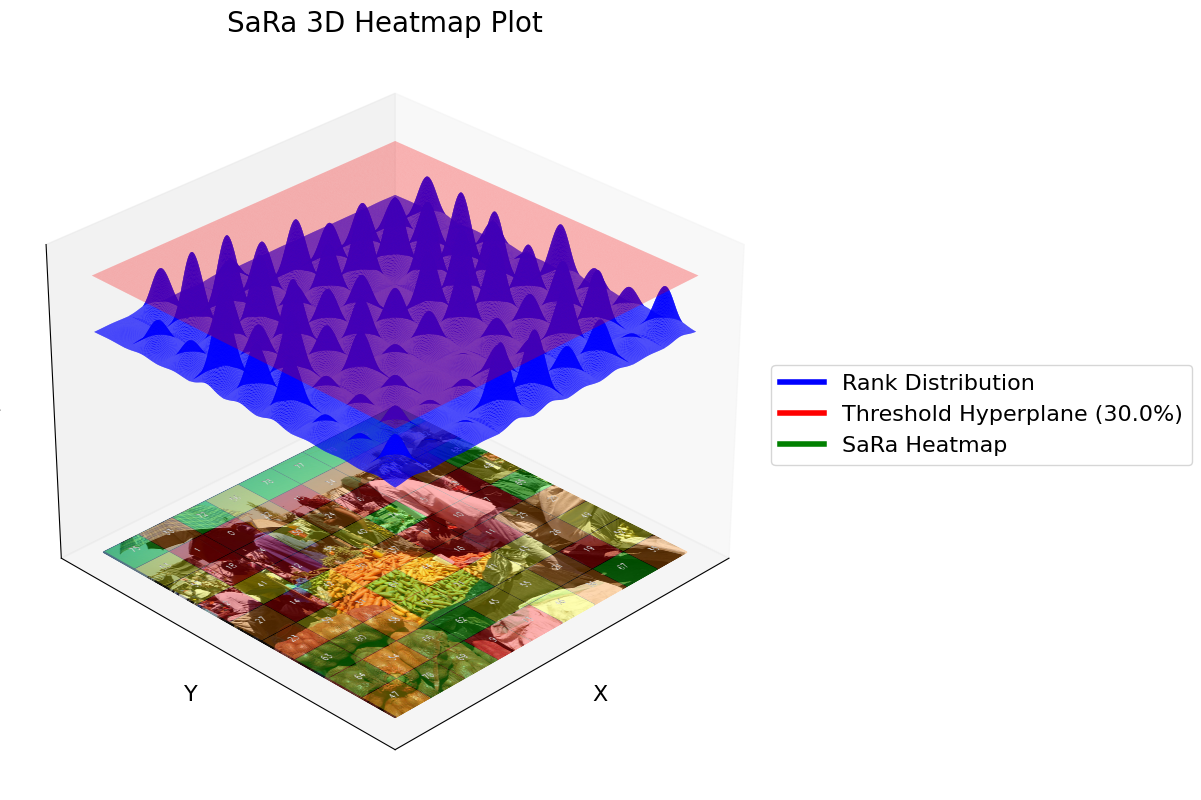

Executing  image 0  000000262145.jpg


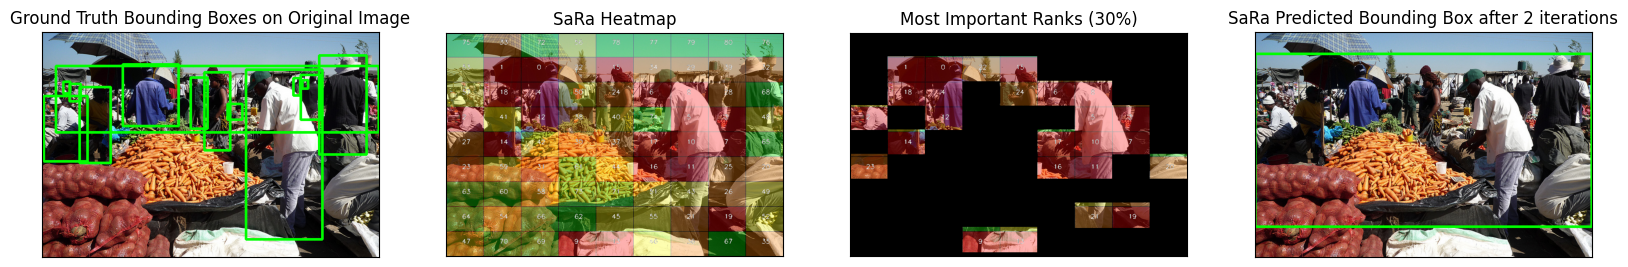

Executing  category 2  bicycle
--------------------------------------------------


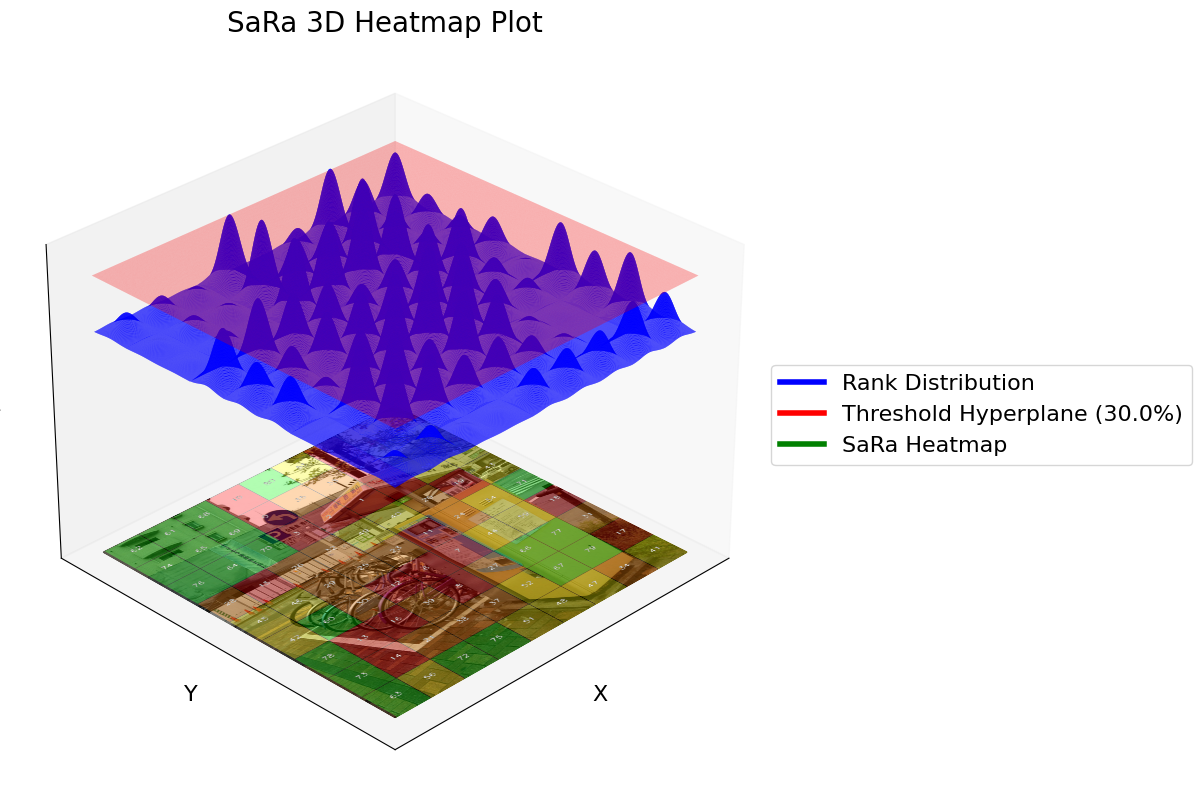

Executing  image 0  000000196610.jpg


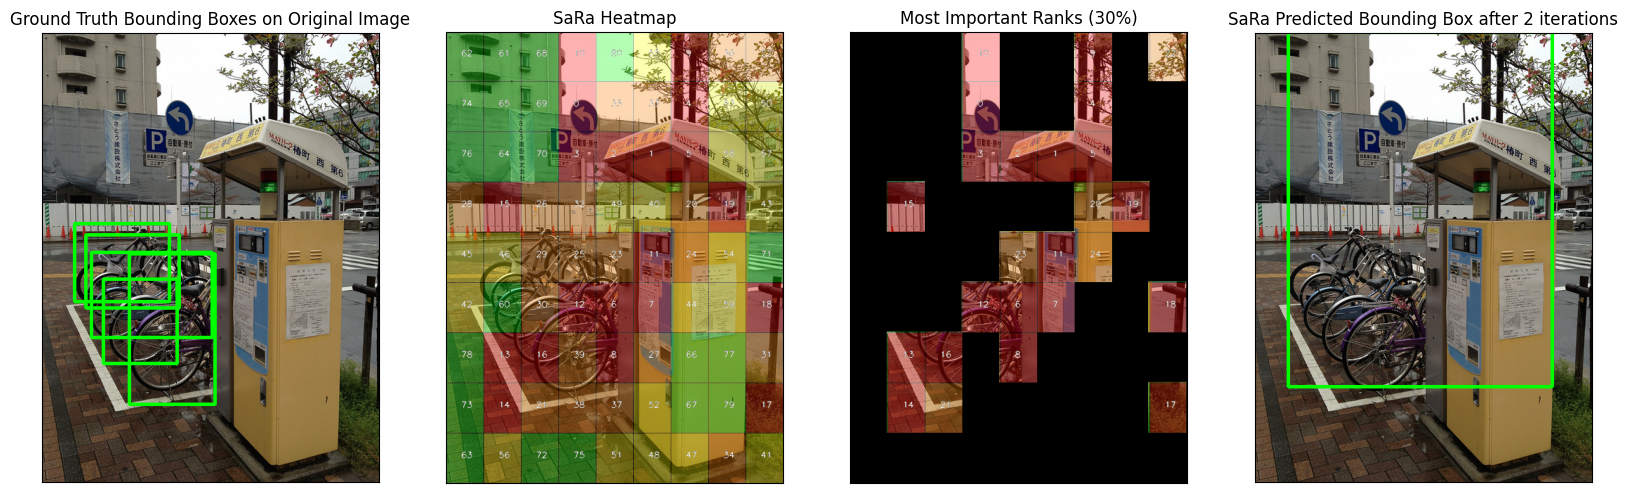

Executing  category 3  car
--------------------------------------------------


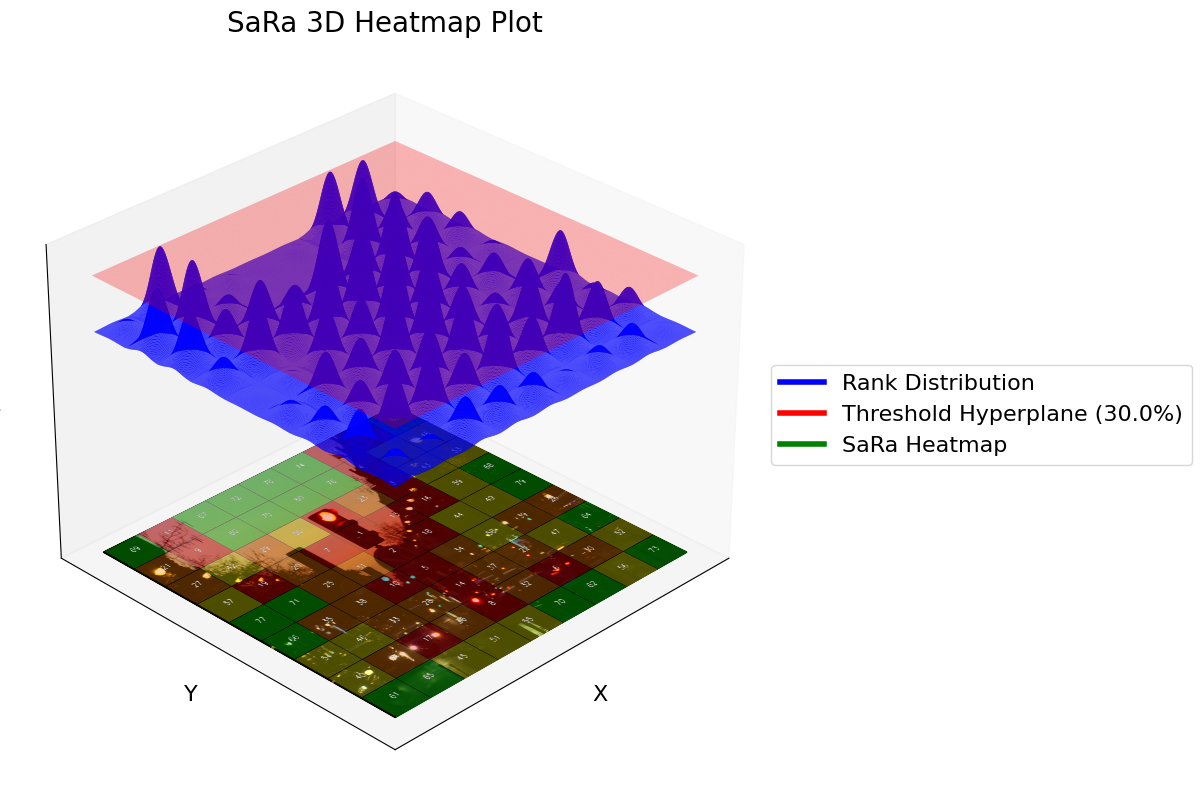

Executing  image 0  000000360449.jpg


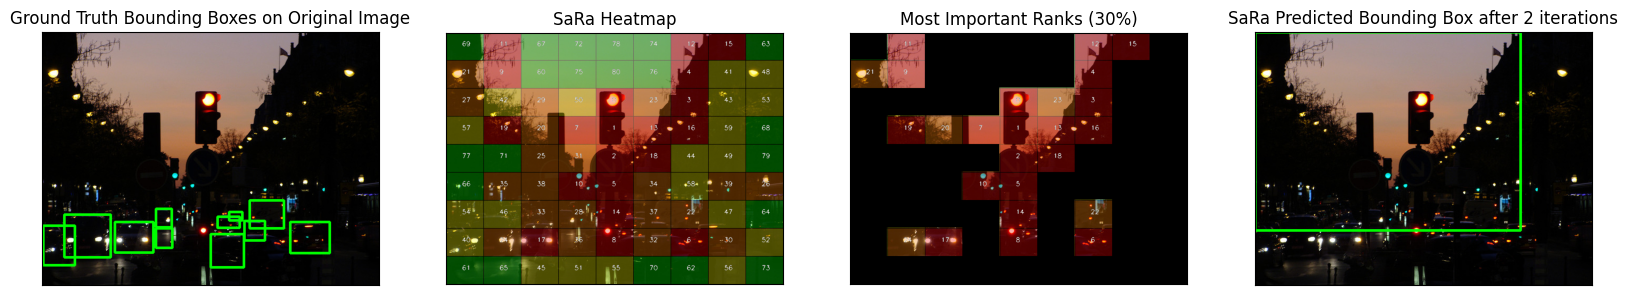

Executing  category 4  motorcycle
--------------------------------------------------


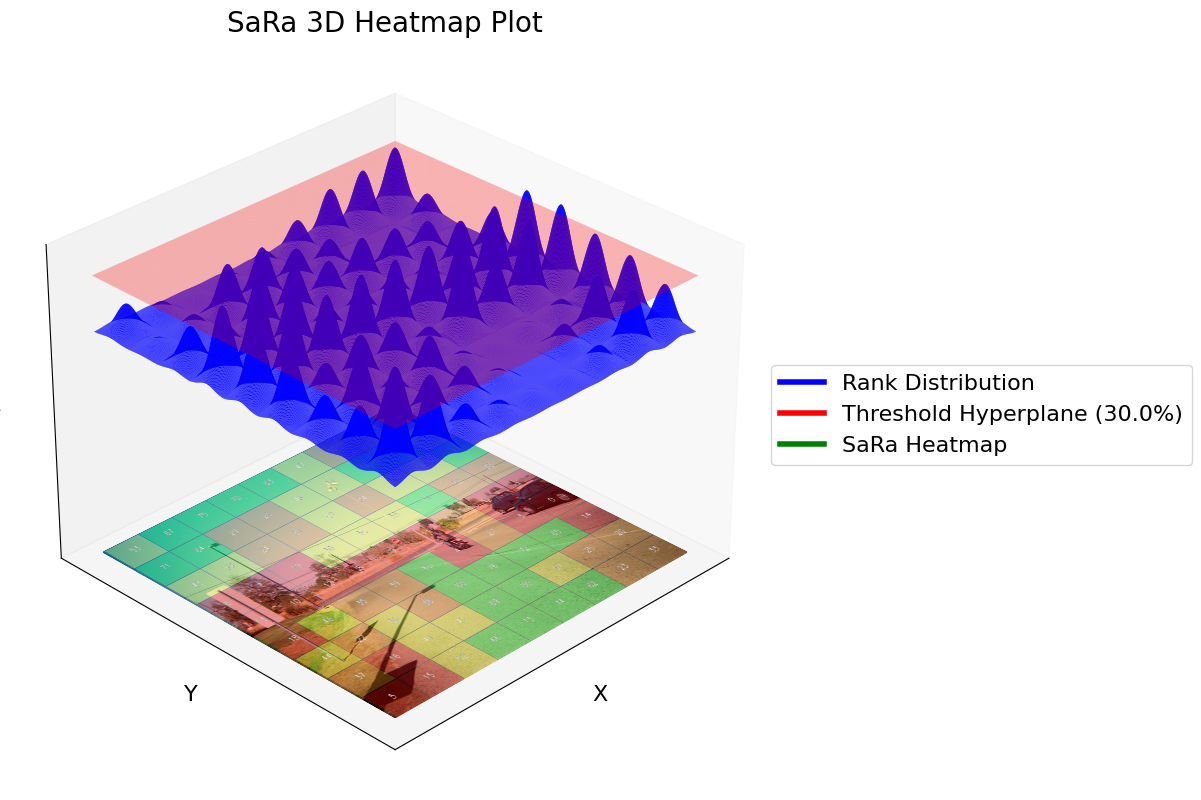

Executing  image 0  000000237568.jpg


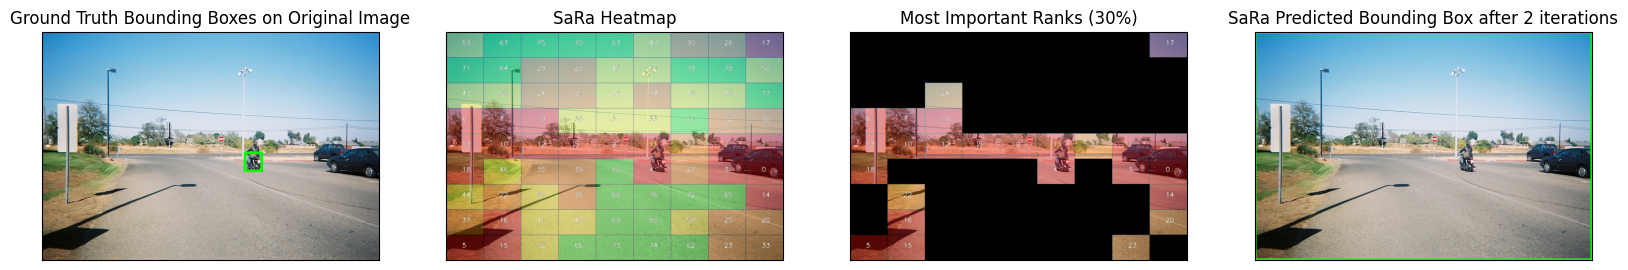

Executing  category 5  airplane
--------------------------------------------------


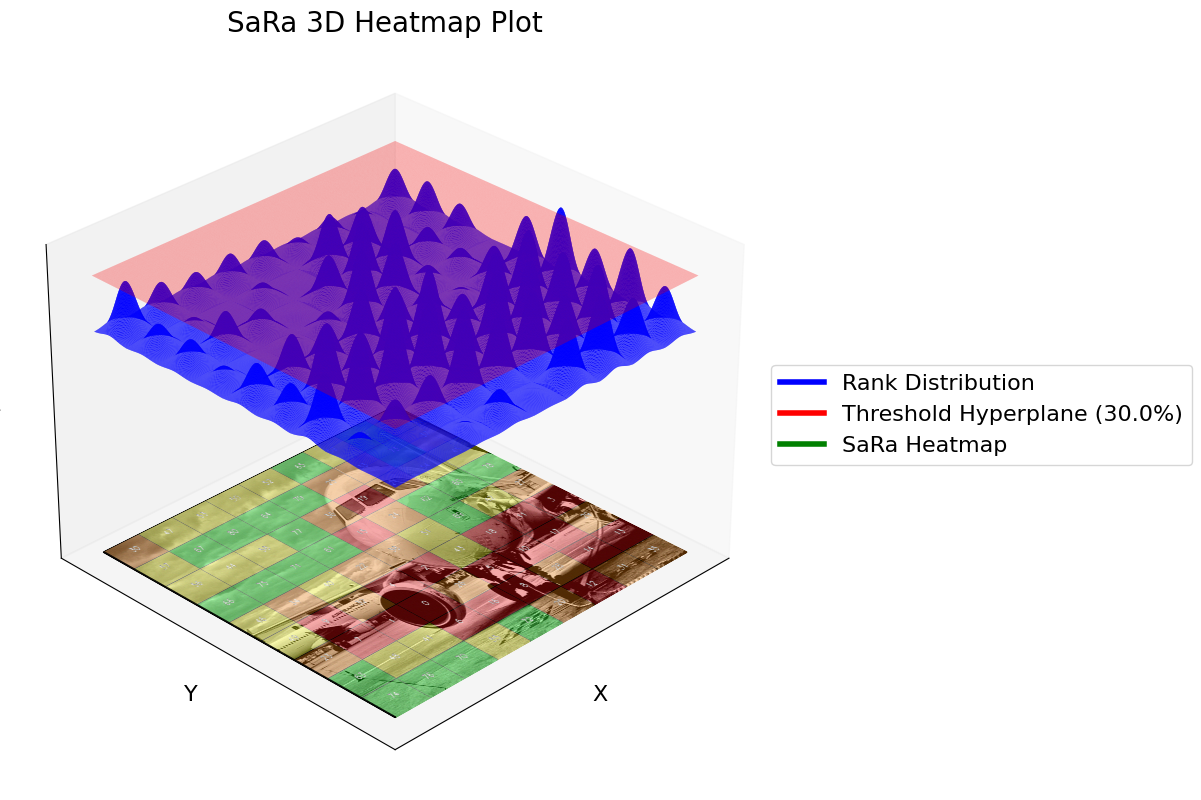

Executing  image 0  000000221184.jpg


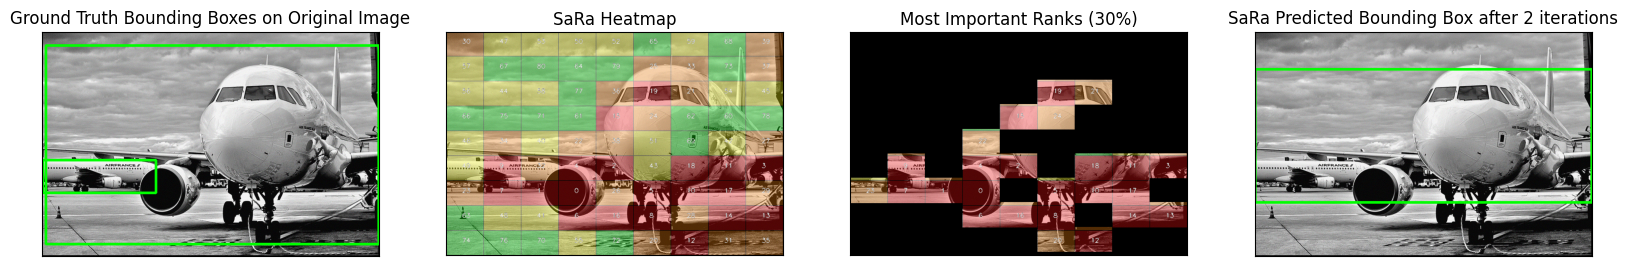

In [9]:
THRESHOLD = 0.3
ITERATIONS = 2
category_count = 5
imgs_list = []

for category_id in category_ids:
    # Retrieving category name
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']

    # Retrieving image IDs containing the current category
    image_ids = coco.getImgIds(catIds=[category_id])

    print('\033[35m' + 'Executing ' + '\033[0m' + ' category ' + str(category_id) + f'\033[34m' + f'  {category_name}' + '\033[0m')
    print('-'*50)
    for idx, image_id in enumerate(image_ids):
        if idx >= subset_count:
            break

        # Loading and preprocessing the image
        image_info = coco.loadImgs(image_id)[0]
        path = f"../Datasets/COCODataset/{data_type}{coco_version}/{image_info['file_name']}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Retrieving the annotations of the current image
        annotation_ids = coco.getAnnIds(imgIds=image_id, catIds=[category_id], iscrowd=None)
        annotations = coco.loadAnns(annotation_ids)

        # Retrieving the bounding boxes of the annotations
        bboxes = [annotation['bbox'] for annotation in annotations]

        # Creating a copy of the image
        sara_image = image.copy()
        sara_image = cv2.cvtColor(sara_image, cv2.COLOR_RGB2BGR)

        # Resetting sara
        sara.reset()

        # Running sara (Original implementation on itti)
        sara_info = sara.return_sara(sara_image, GRID_SIZE, generator, mode=1)

        # Extracting heatmap from sara
        heatmap = sara_info[0]
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Retrieving important ranks from SaRa
        cropped_img , most_imp_ranks, sara_bbox = sara.sara_resize(image.copy(), sara_info, GRID_SIZE, rate=THRESHOLD, iterations=ITERATIONS)

        sara.plot_3D(image.copy(), sara_info, GRID_SIZE, rate=THRESHOLD)

        # Converting 3-channel binary image to single-channel
        most_imp_ranks_single = cv2.cvtColor(most_imp_ranks, cv2.COLOR_RGB2GRAY)

        # Ensuring the mask is of type uint8 and has the same size as the source images
        most_imp_ranks_single = most_imp_ranks_single.astype('uint8')
        most_imp_ranks_single = cv2.resize(most_imp_ranks_single, (heatmap.shape[1], heatmap.shape[0]))

        # Ensuring the source images are of type uint8
        heatmap = heatmap.astype('uint8')

        # Performing bitwise and operation to get the most important ranks
        sara_most_imp_ranks = cv2.bitwise_and(heatmap.copy(), heatmap.copy(), mask=most_imp_ranks_single)

        gt_image = image.copy()
        # Iterating through the bounding boxes and plotting them on the image
        for bbox in bboxes:
            x, y, w, h = list(map(int, bbox))
            cv2.rectangle(gt_image, (x, y), (x + w, y + h), (0, 255, 0), 3)
            
        predicted_image = cv2.rectangle(image.copy(), (sara_bbox[1], sara_bbox[0]), (sara_bbox[3], sara_bbox[2]), (0, 255, 0), 3)

        imgs_list.append([gt_image, heatmap, sara_most_imp_ranks, predicted_image])
        
        print('\033[35m' + 'Executing ' + '\033[0m' + ' image ' + str(idx) + f'\033[34m' + f'  {image_info["file_name"]}' + '\033[0m')
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))

        # The Ground Truth Bounding Box on the Original Image
        axs[0].imshow(gt_image)
        axs[0].set_title('Ground Truth Bounding Boxes on Original Image')

        # The SaRa Heatmap
        axs[1].imshow(heatmap)
        axs[1].set_title('SaRa Heatmap')

        # The Most Important Ranks
        axs[2].imshow(sara_most_imp_ranks)
        axs[2].set_title('Most Important Ranks (%.f%%)' % (THRESHOLD * 100))

        # # The Cropped Image
        # axs[3].imshow(cropped_img)
        # axs[3].set_title('The Cropped Image')

        # The Predicted Bounding Box on the Original Image
        axs[3].imshow(predicted_image)
        axs[3].set_title('SaRa Predicted Bounding Box after %d iterations' % ITERATIONS)

        # Removing the x and y ticks
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()
        
        break
    
    category_count -= 1

    if category_count == 0:
        break

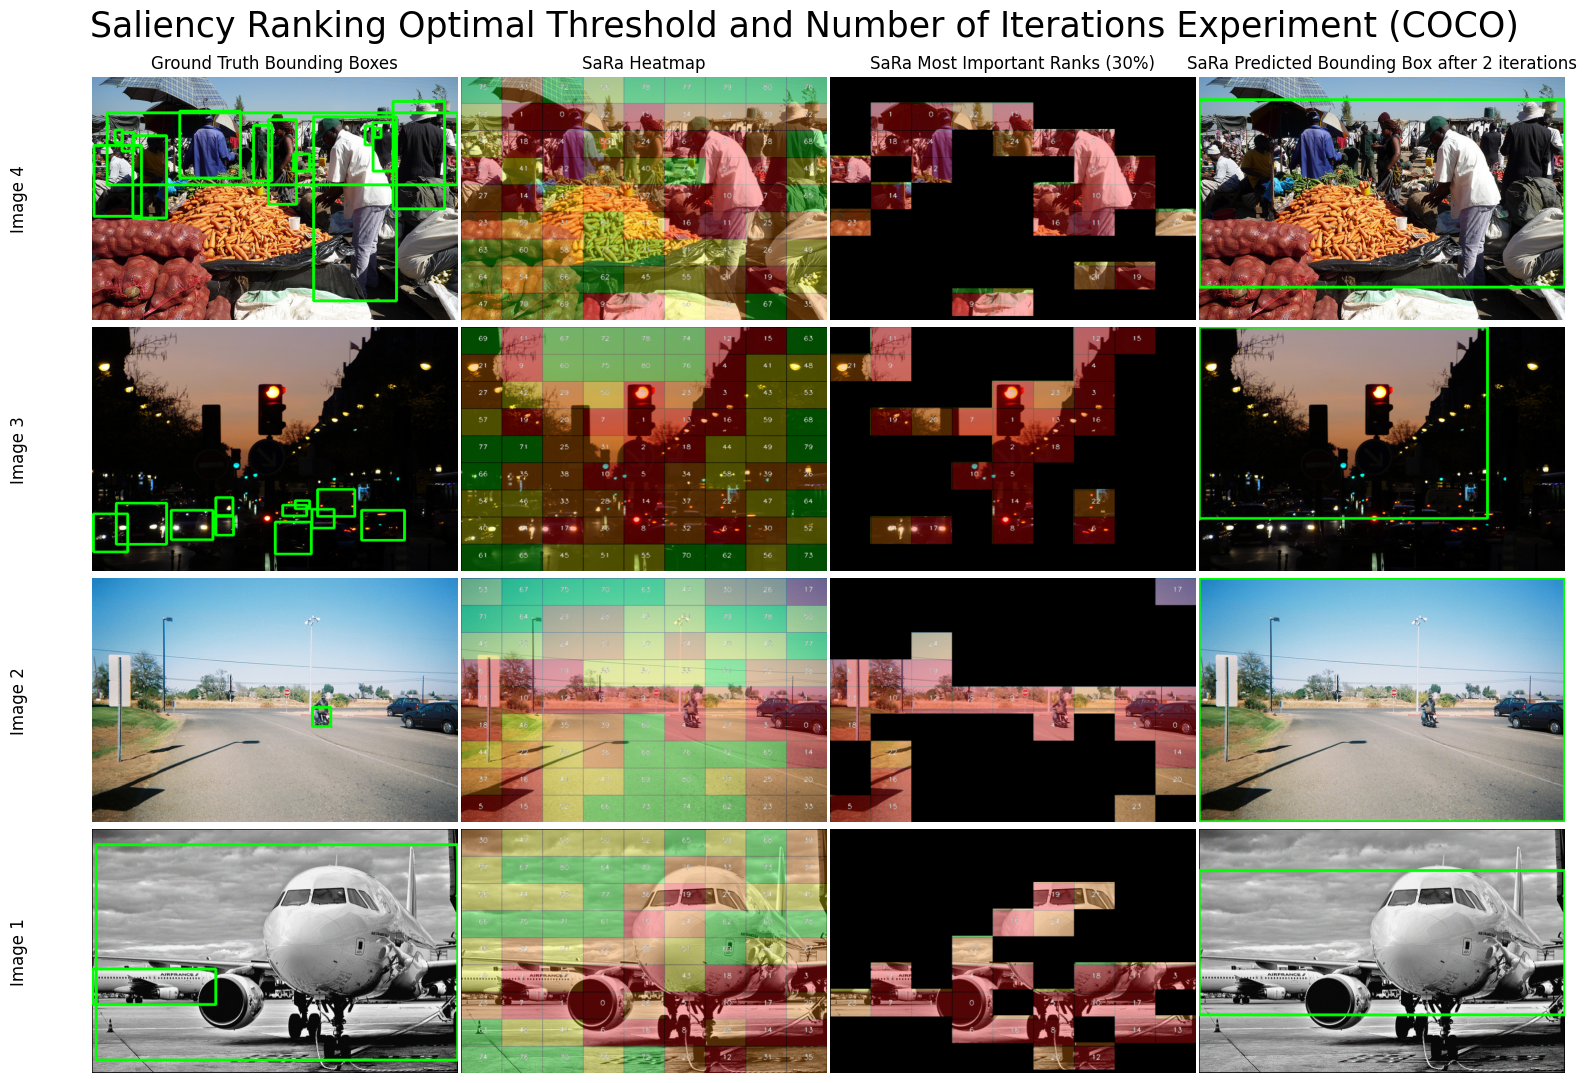

In [10]:
# Plotting the images
fig, axs = plt.subplots(len(imgs_list) - 1, 4, figsize=(19, 13))

# Defining the labels for the columns
column_labels = ["Ground Truth Bounding Boxes", "SaRa Heatmap", "SaRa Most Important Ranks (%.f%%)" % (THRESHOLD * 100), "SaRa Predicted Bounding Box after %d iterations" % ITERATIONS]

# Getting the size of the first image
size = imgs_list[0][0].shape

# Resize all the images to the same size
for i in range(len(imgs_list)):
    for j in range(4):
        imgs_list[i][j] = cv2.resize(imgs_list[i][j], (size[1], size[0]))

# Setting the column labels
for ax, col in zip(axs[0], column_labels):
    ax.set_title(col)

# Plotting the images
axs_row = 0
for i in range(len(imgs_list)):
    # Skipping the second image
    if i == 1:
        continue
    for j in range(4):
        axs[axs_row, j].imshow(imgs_list[i][j])
        axs[axs_row, j].axis('off')
    axs_row += 1

# Adding a label next to each row of images
for i, ax in enumerate(axs):
    ax[0].text(-0.2, 0.5, f'Image {len(imgs_list)-1 -i}', ha='center', va='center', rotation='vertical', fontsize=12, transform=ax[0].transAxes)

# Adding a title for the entire figure
fig.suptitle('Saliency Ranking Optimal Threshold and Number of Iterations Experiment (COCO)', fontsize=25, y=0.93)
# fig.suptitle('Saliency Ranking Pipeline in Object Detection', fontsize=25, y=0.92)

# Adjusting the spacing between the subplots
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.show()

**<h3> Testing Saliency Ranking with different Iterations on the Itti Saliency Map </h3>**

In [11]:
# In order to save the results, set the do_experiment variable to True
do_experiment = False

In [12]:
# Running the experiment
if do_experiment:
    ITERATIONS = list(range(1, 5))
    THRESHOLD = 0.3

    SAVE_PATH = 'Threshold Experiment (Taking best bbox from SaRa (Iterations))'
    if not os.path.exists(SAVE_PATH):
        os.mkdir(SAVE_PATH)

    # Iterating through the iterations
    for iteration in ITERATIONS:
        # Printing the current iteration
        print('*' * 50)
        print(f'Executing iteration {iteration}')
        print('*' * 50)

        # Initializing the store dictionary
        store_dict = {'Iterations':iteration, 'Grid Size': GRID_SIZE, 'Total IoU': 0, 'Generator': generator,'Total Recall': 0, 'Total Images': 0, 'Total Ratio Cropped': 0, 'Category': {}}

        # For all the categories in category_dict. values(), appending to the store_dict
        for category in category_dict.values():
            store_dict['Category'][category] = {'Total IoU': 0, 'Total Recall': 0, 'Total Images': 0, 'Total Ratio Cropped': 0}

        for category_id in category_ids:
            # Retrieving category name
            category_info = coco.loadCats(category_id)[0]
            category_name = category_info['name']

            # Retrieving image IDs containing the current category
            image_ids = coco.getImgIds(catIds=[category_id])

            print('\033[35m' + 'Executing ' + '\033[0m' + ' category ' + str(category_id) + f'\033[34m' + f'  {category_name}' + '\033[0m')
            print('-'*50)
            for idx, image_id in enumerate(image_ids):
                if idx >= subset_count:
                    break

                # Loading and preprocessing the image
                image_info = coco.loadImgs(image_id)[0]
                path = f"../Datasets/COCODataset/{data_type}{coco_version}/{image_info['file_name']}"
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Retrieving the annotations of the current image
                annotation_ids = coco.getAnnIds(imgIds=image_id, catIds=[category_id], iscrowd=None)
                annotations = coco.loadAnns(annotation_ids)

                # Retrieving the bounding boxes of the annotations
                bboxes = [annotation['bbox'] for annotation in annotations]

                # Creating a copy of the image
                sara_image = image.copy()

                # Resetting sara
                sara.reset()

                # Running sara (Original implementation on itti)
                sara_info = sara.return_sara(sara_image, GRID_SIZE, generator, mode=2)

                # Retrieving important ranks from SaRa
                cropped_img , most_imp_ranks, sara_bbox = sara.sara_resize(image.copy(), sara_info, GRID_SIZE, rate=THRESHOLD, iterations=iteration)

                # Calculating the ratio area of the cropped image to the original image
                ratio_cropped = calculate_ratio_cropped(cropped_img, image)

                # Calculating the IoU between the cropped image and the ground truth
                iou_cropped = calculate_best_iou([sara_bbox], bboxes)

                # Calculating the recall between the cropped image and the ground truth
                recall_cropped = calculate_best_recall([sara_bbox], bboxes)

                # Saving to store_dict
                store_dict['Total IoU'] += iou_cropped
                store_dict['Total Recall'] += recall_cropped
                store_dict['Total Images'] += 1
                store_dict['Total Ratio Cropped'] += ratio_cropped

                store_dict['Category'][category_name]['Total IoU'] += iou_cropped
                store_dict['Category'][category_name]['Total Recall'] += recall_cropped
                store_dict['Category'][category_name]['Total Images'] += 1
                store_dict['Category'][category_name]['Total Ratio Cropped'] += ratio_cropped

        print('\033[32m' + 'Completed' + '\033[0m')
        print('*'*50)

        # Saving the store_dict
        np.save(os.path.join(SAVE_PATH, f'Iterations_{iteration}_Threshold_{THRESHOLD}_Grid_Size_{GRID_SIZE}_Generator_{generator}.npy'), store_dict)

**<h3> Evaluation of the different Number of Iterations </h3>**

Iteration with the highest average IoU: 2 with average IoU: 0.10574029836606624 over 78018 images


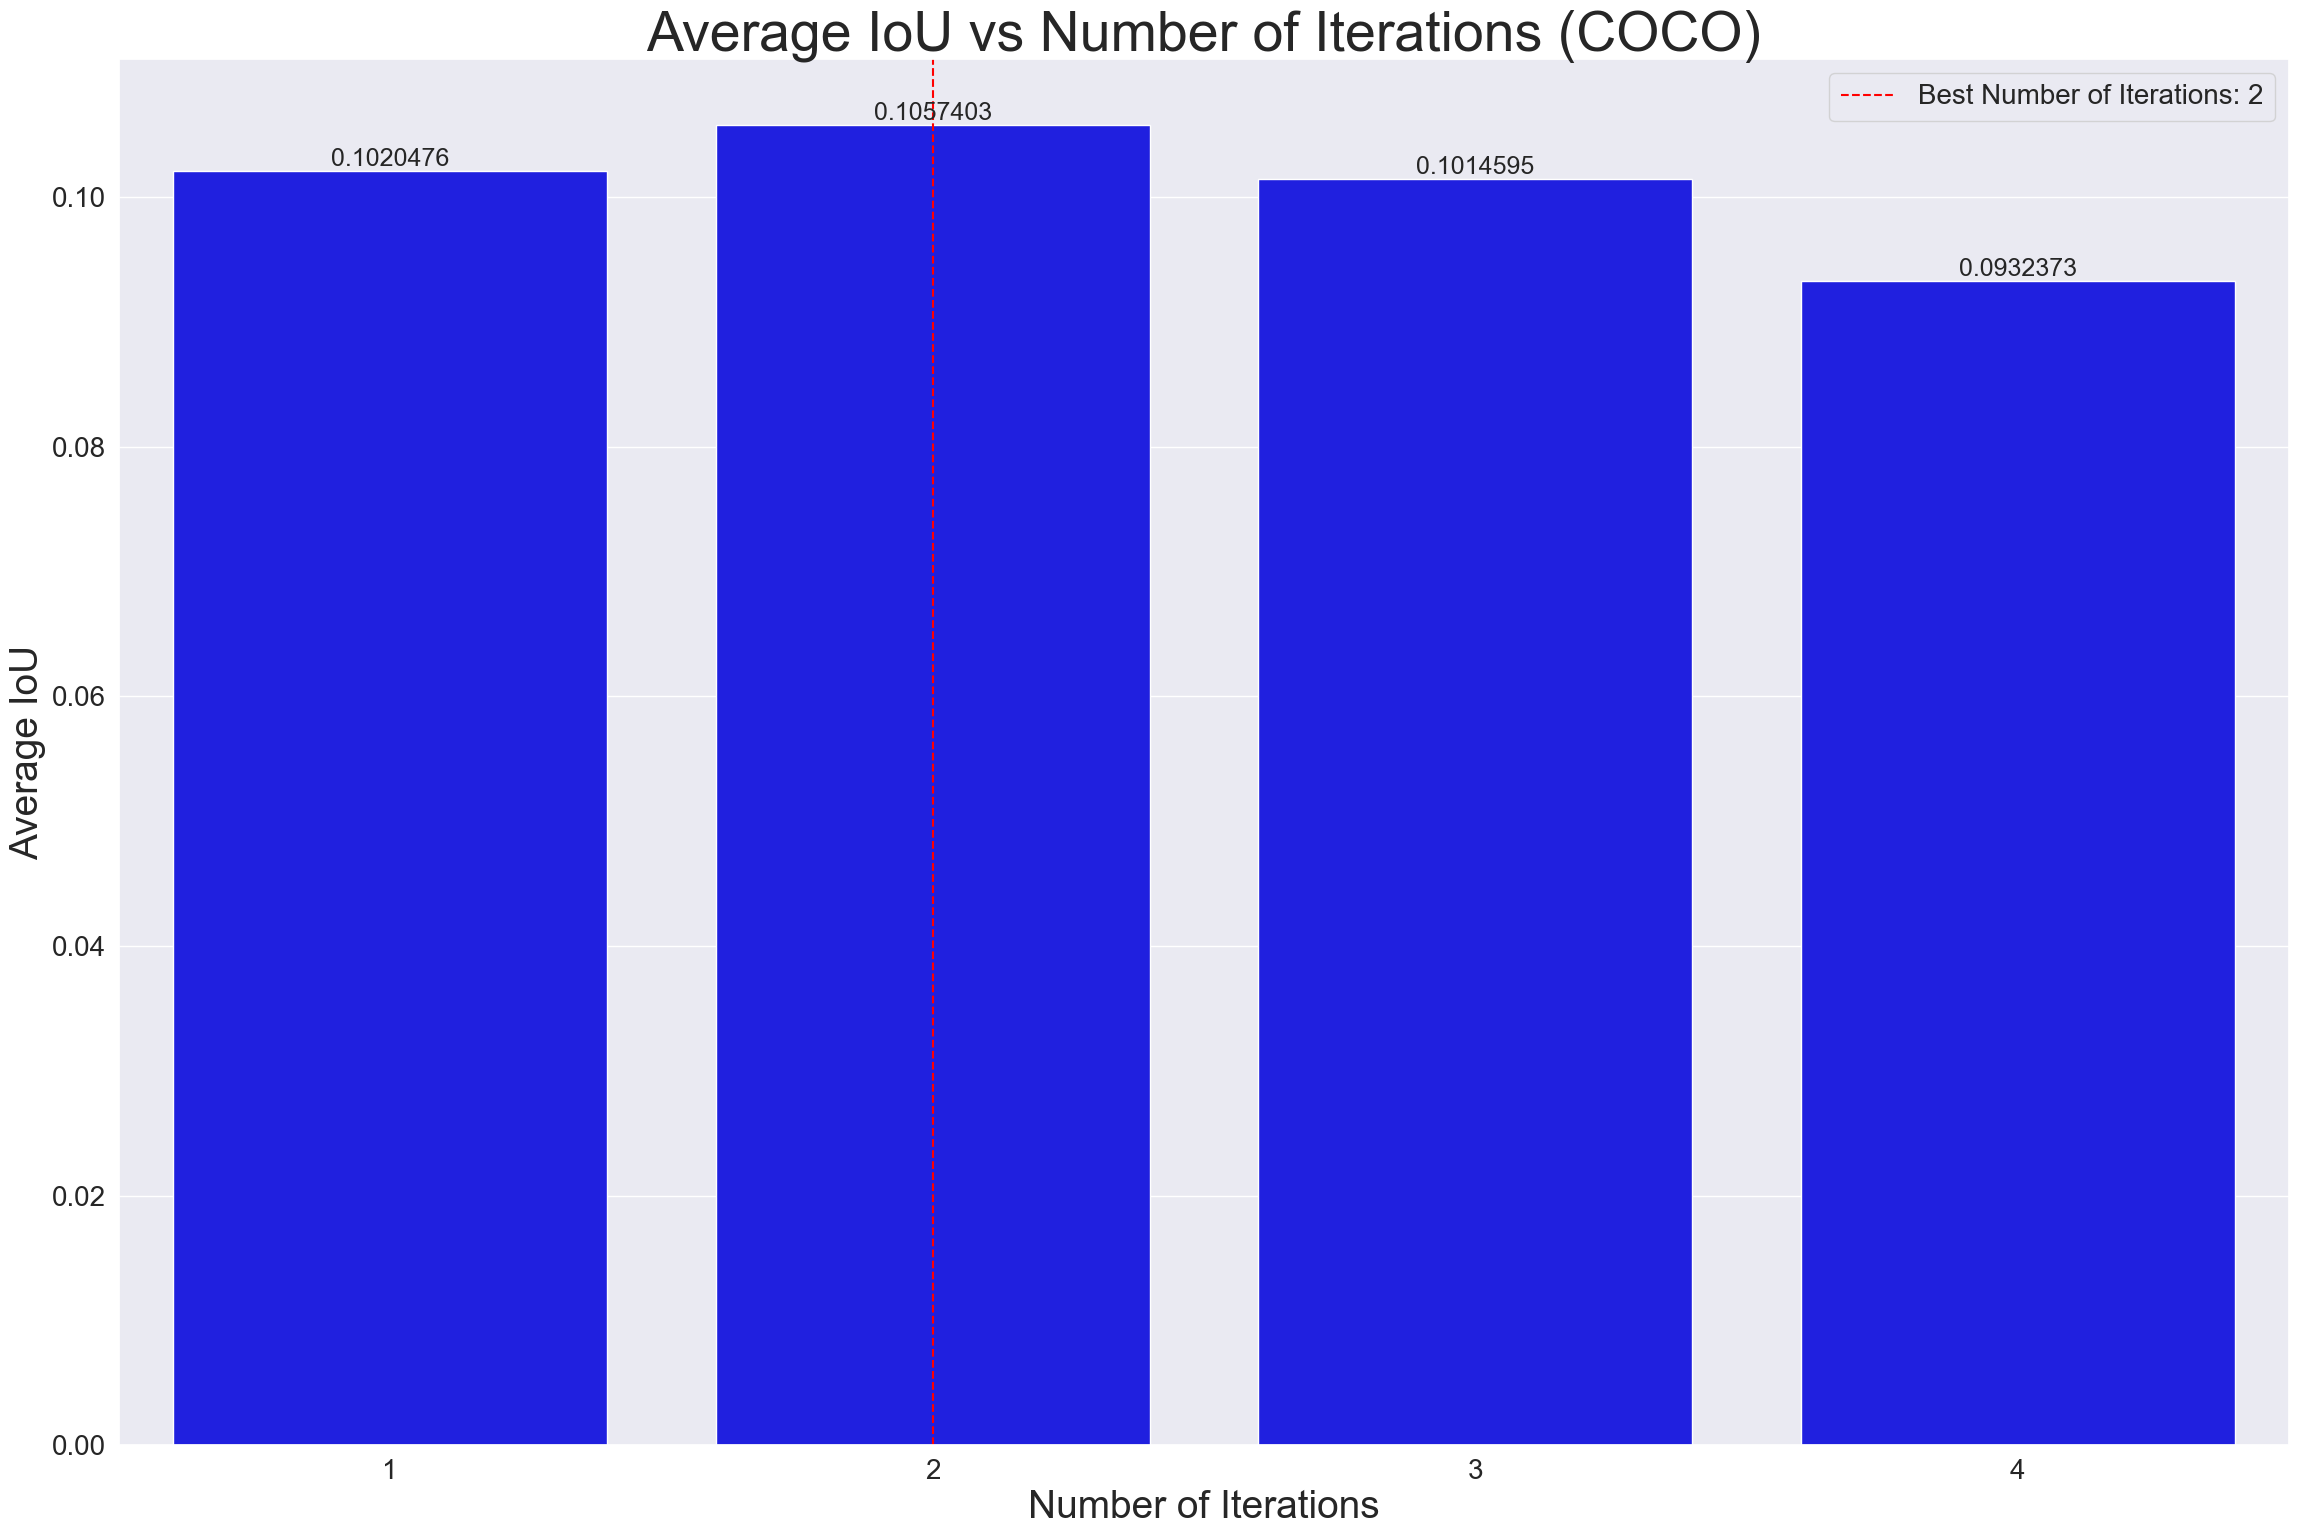

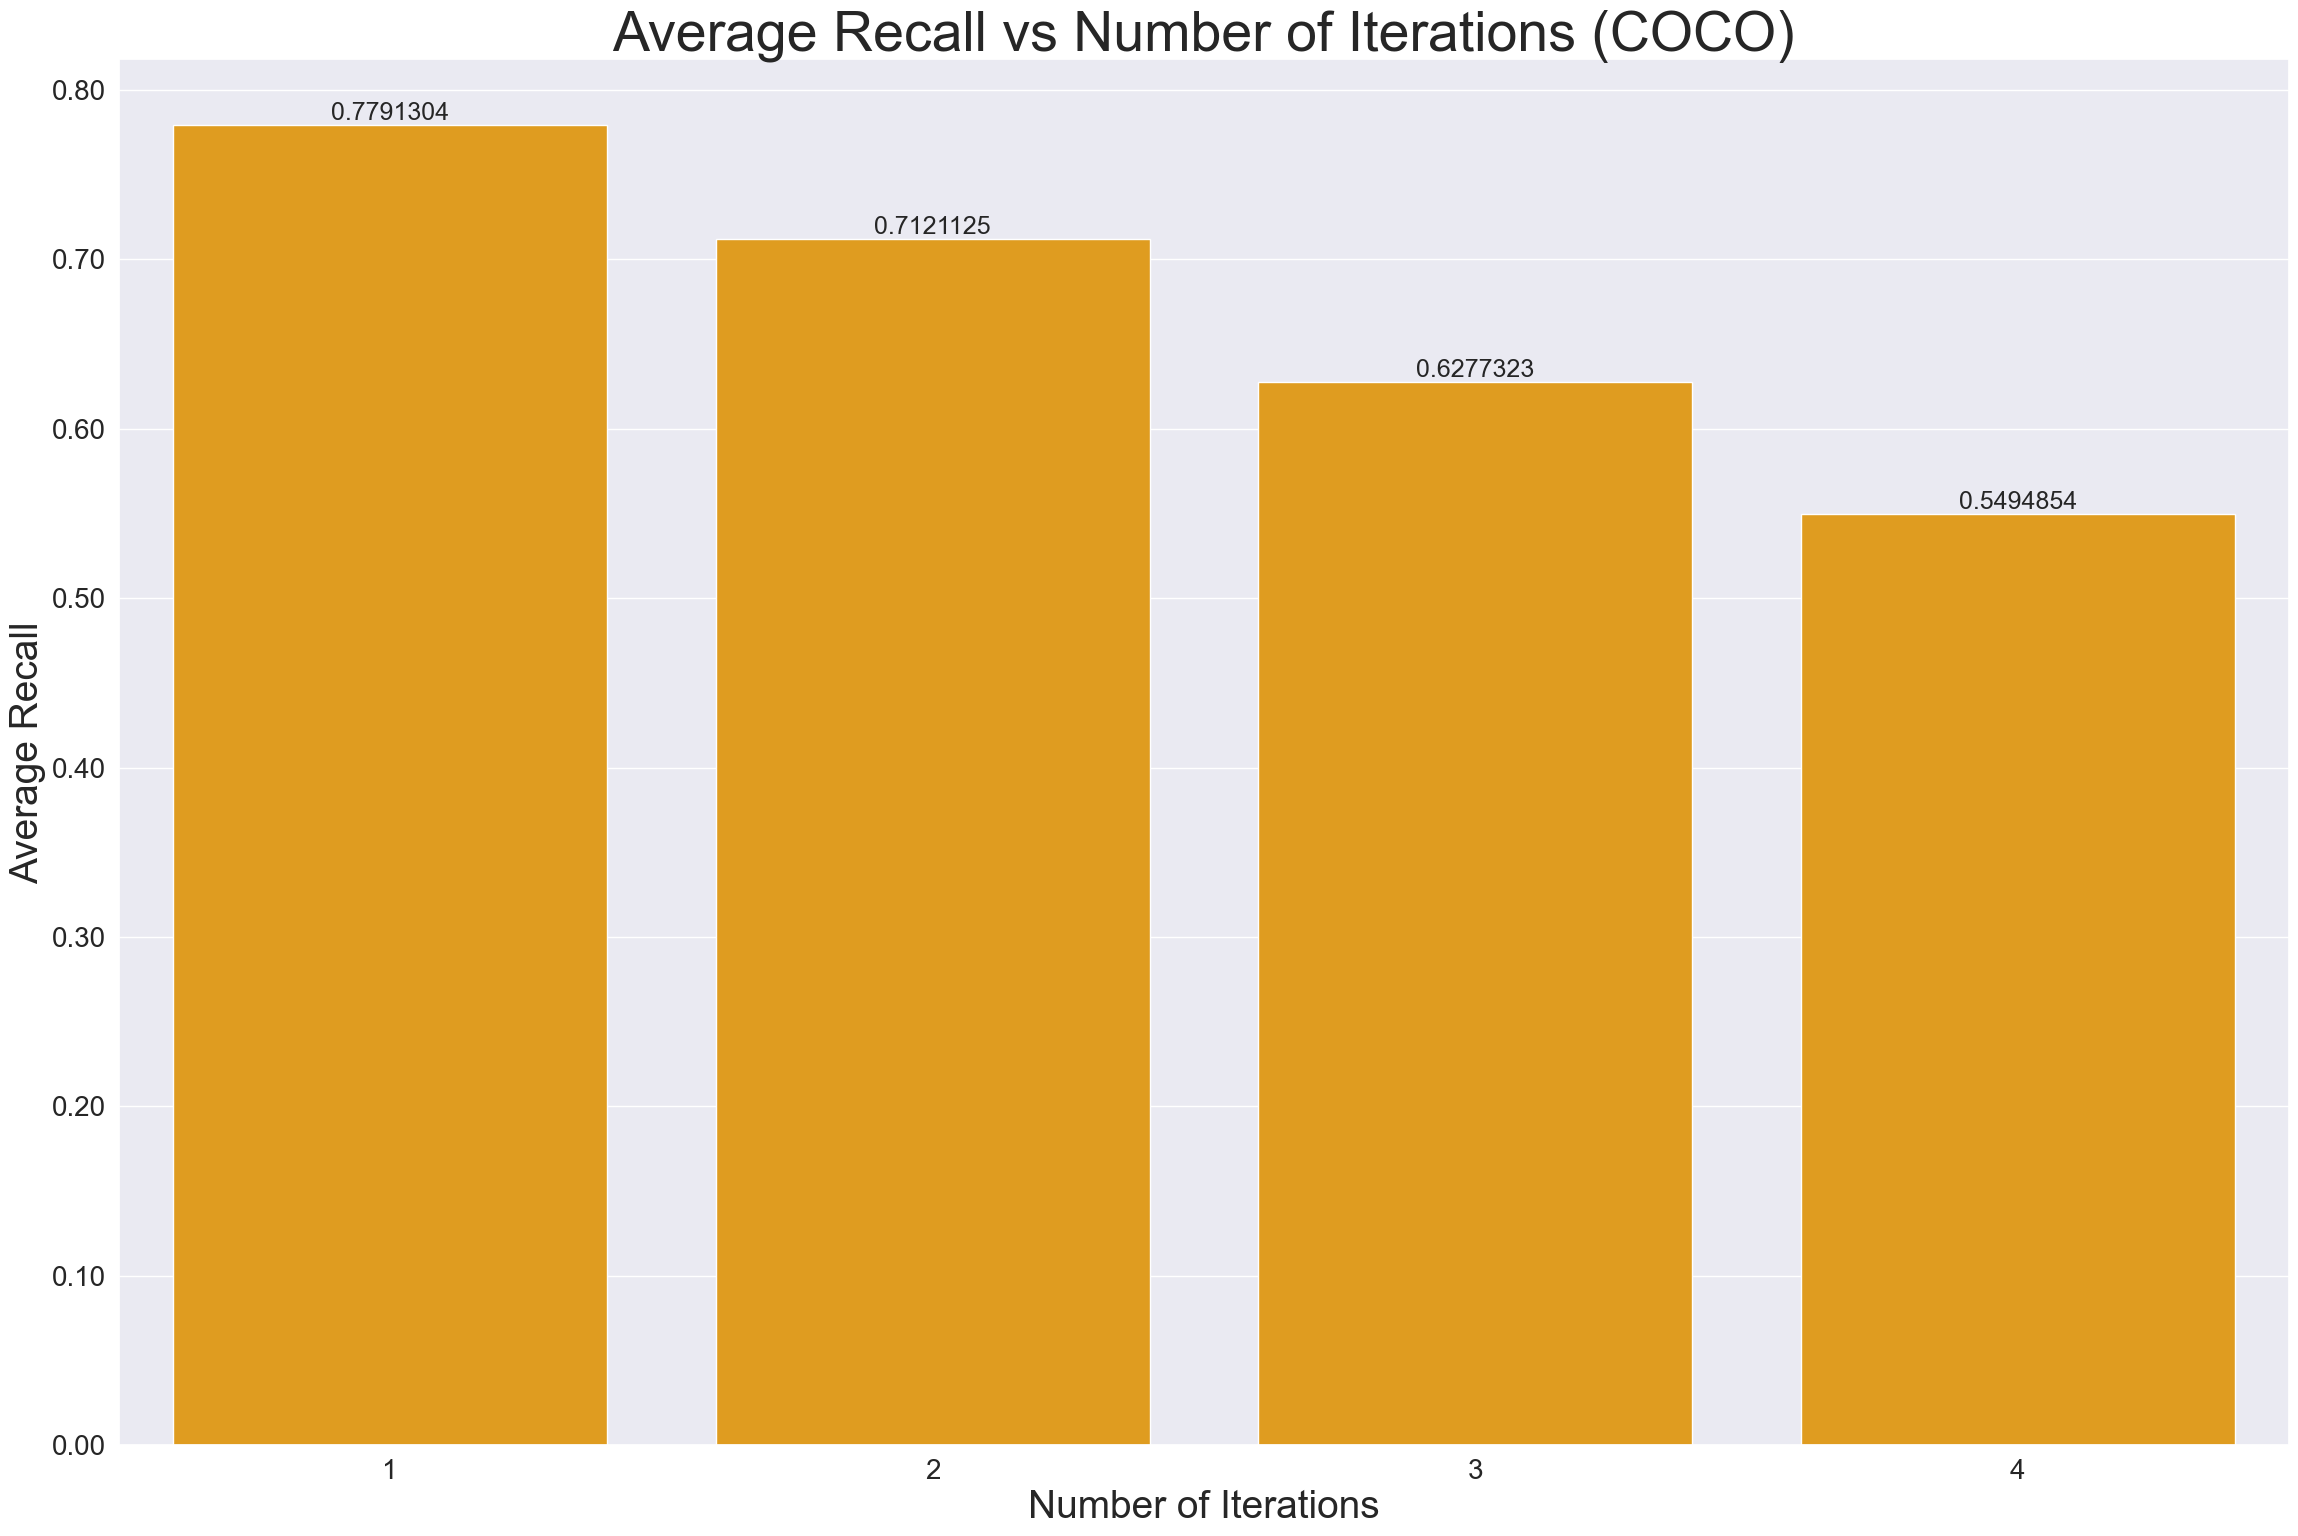

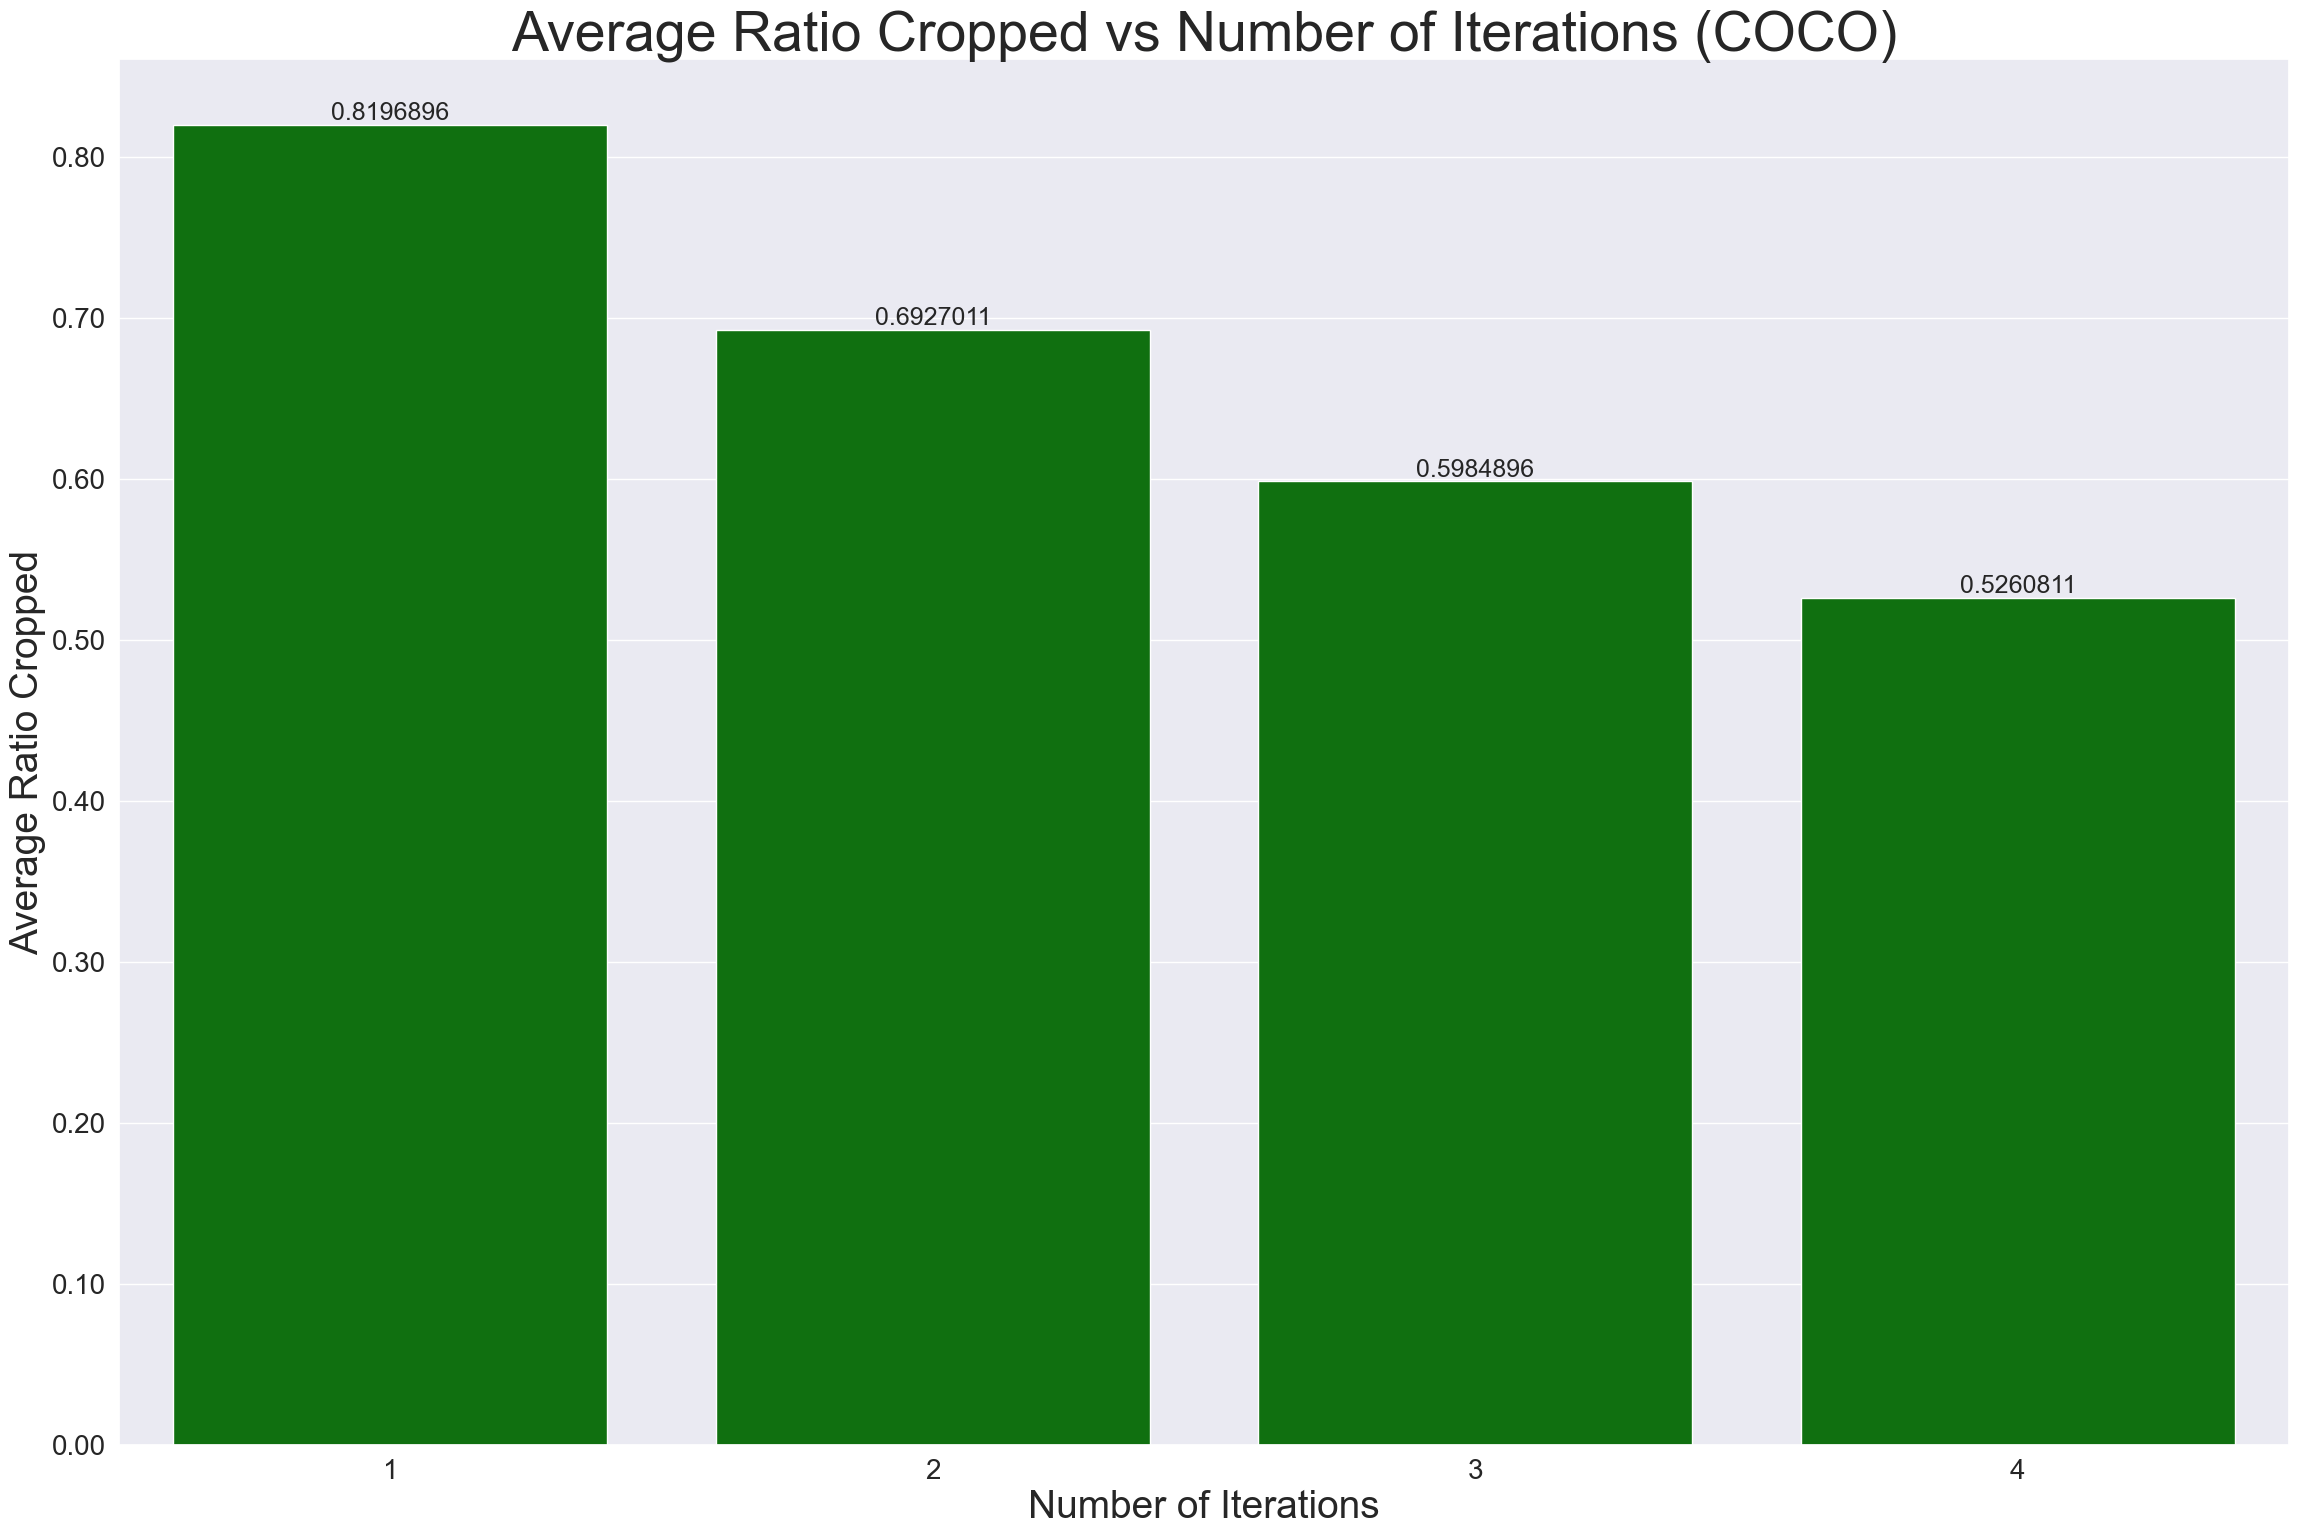

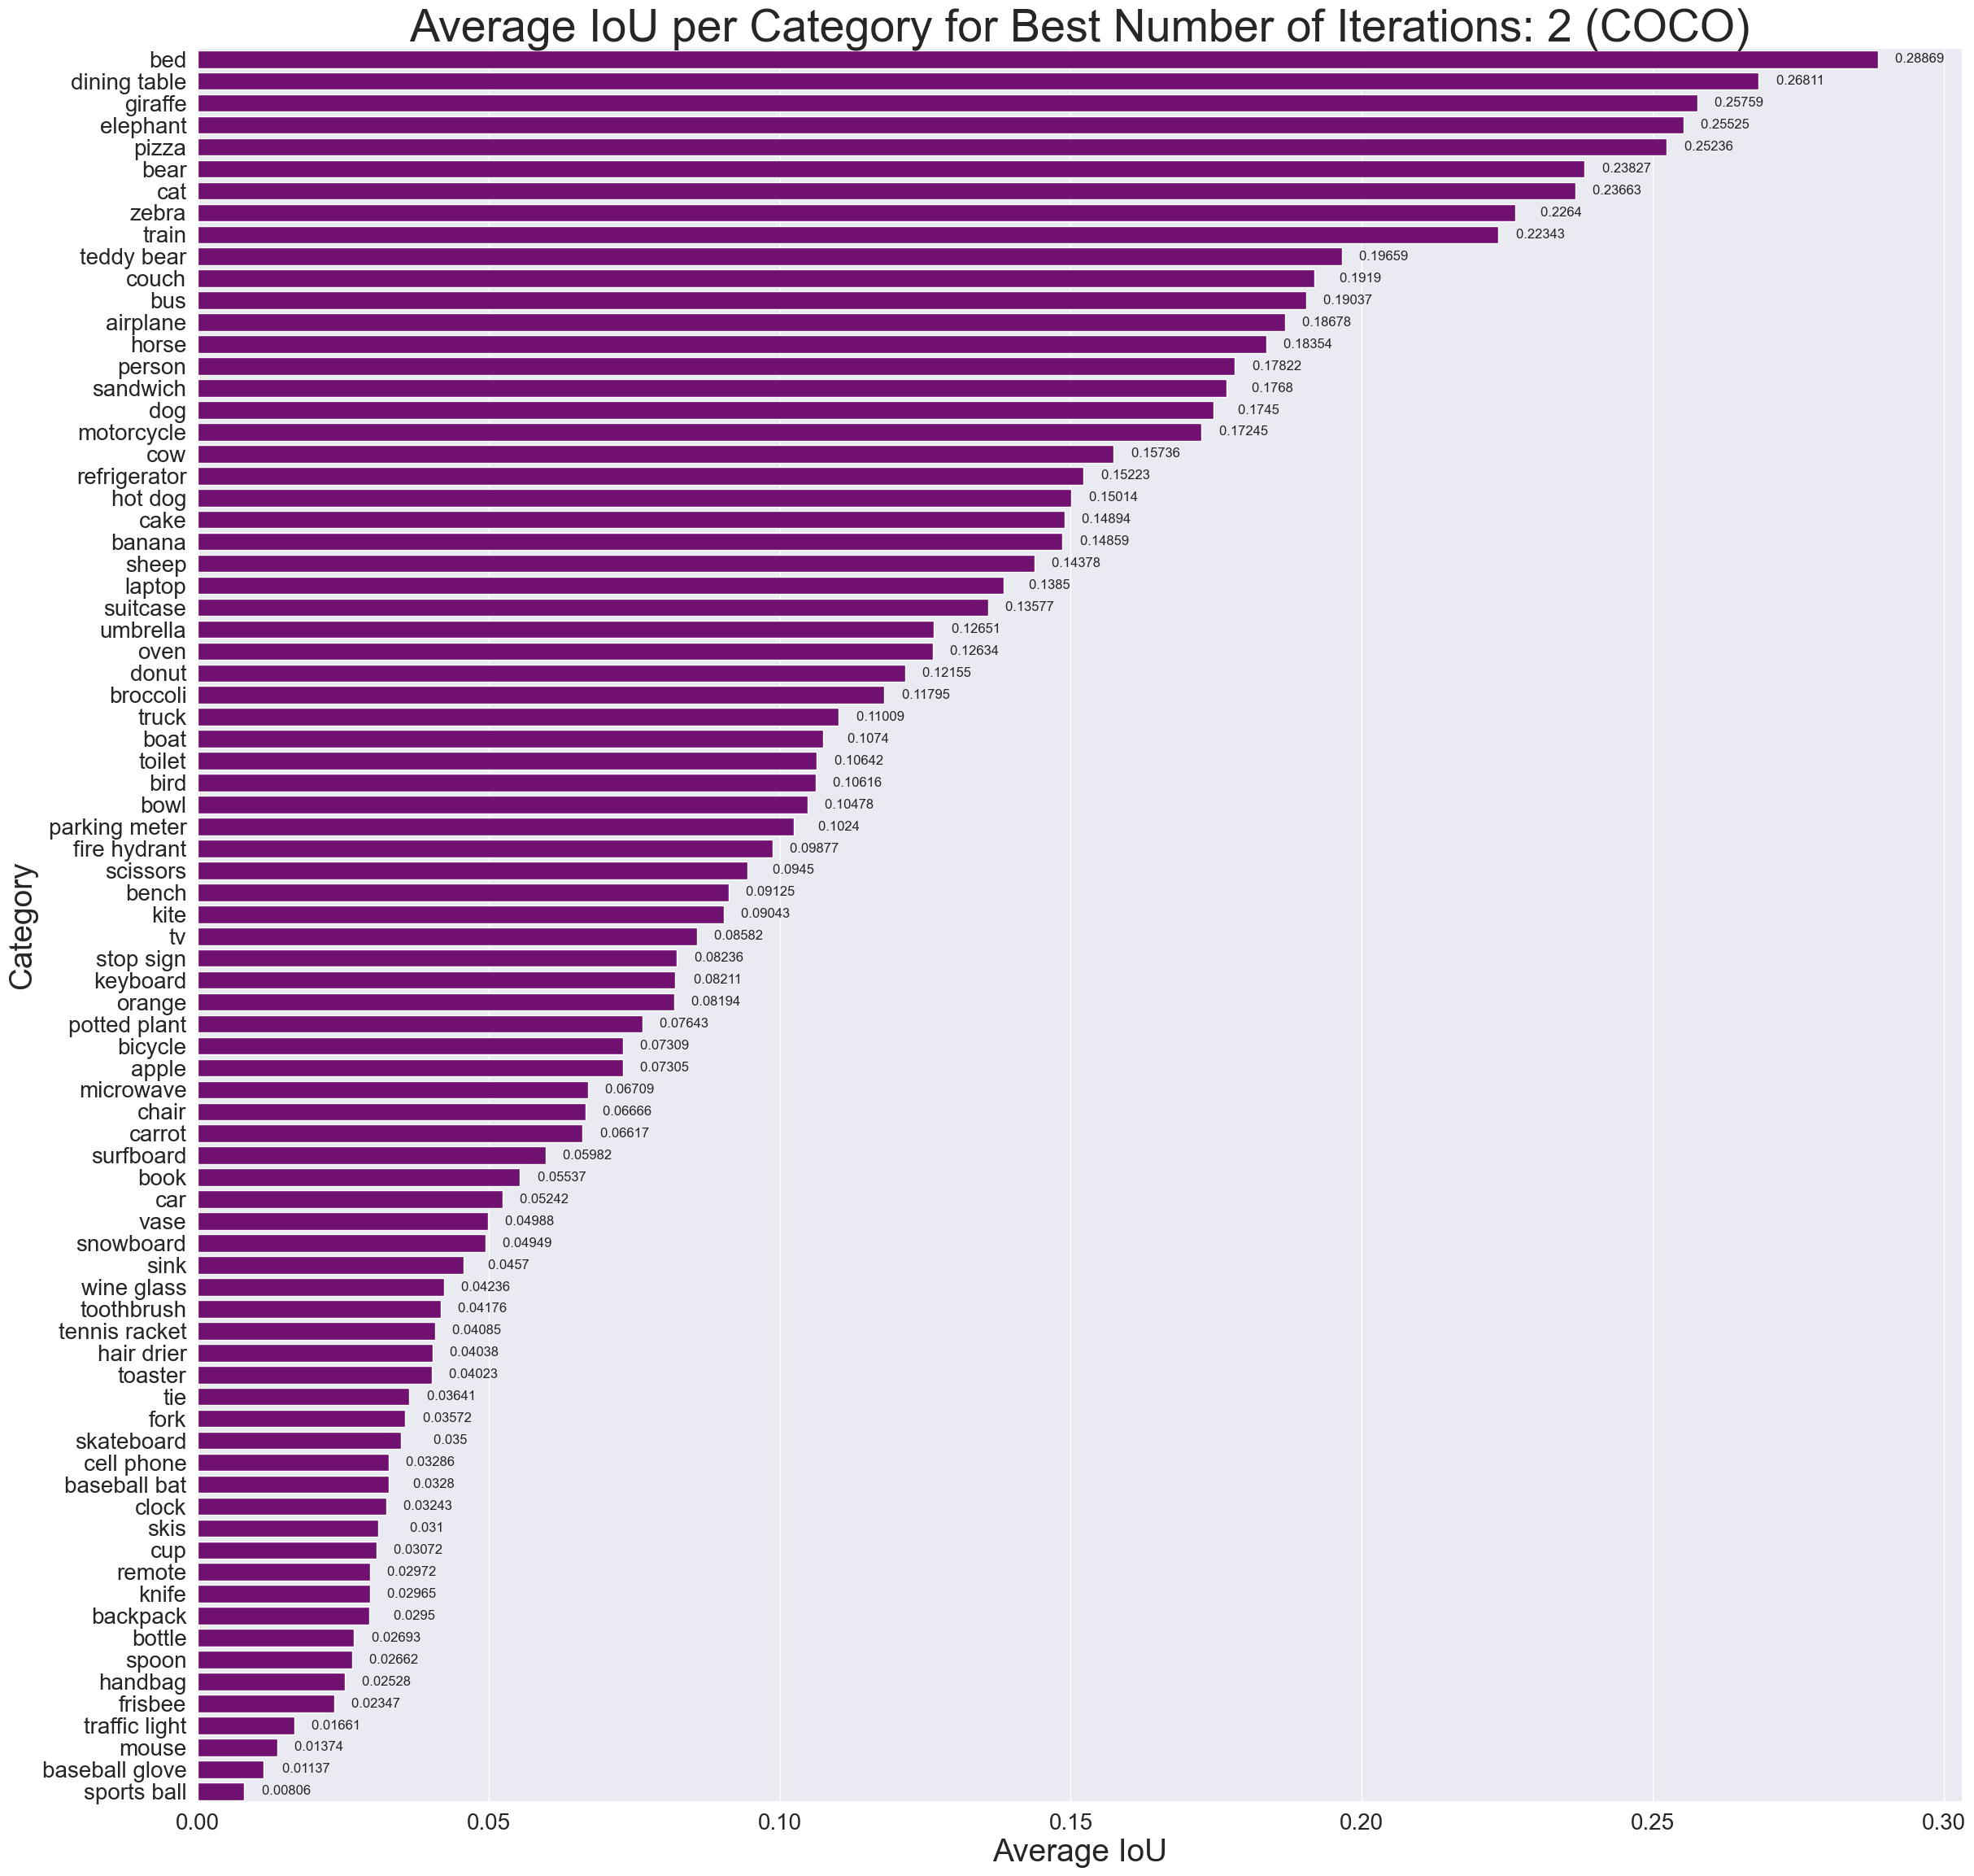

In [13]:
SAVE_PATH = 'Threshold Experiment (Taking best bbox from SaRa (Iterations))'

# Loading all the files in the SAVE_PATH in a list of store_dict
store_dict_list = []
for file in os.listdir(SAVE_PATH):
    if file.endswith('.npy'):
        store_dict_list.append(np.load(os.path.join(SAVE_PATH, file), allow_pickle=True).item())

# Calculating the average for all the store_dict in the store_dict_list
avg_stored_dict = {}

# Iterating through all the store_dict in the store_dict_list
for store_dict in store_dict_list:
    # Calculating the average IoU, Recall and Ratio Cropped for the store_dict
    avg_iou = store_dict['Total IoU'] / store_dict['Total Images']

    avg_recall = store_dict['Total Recall'] / store_dict['Total Images']

    avg_ratio_cropped = store_dict['Total Ratio Cropped'] / store_dict['Total Images']

    # Saving the average IoU, Recall and Ratio Cropped to the avg_stored_dict
    avg_stored_dict[store_dict['Iterations']] = {'Total IoU': avg_iou, 'Total Recall': avg_recall, 'Total Ratio Cropped': avg_ratio_cropped}

# Normalising the average IoU, Recall and Ratio Cropped for the avg_stored_dict as probabilities between 0 and 1 through Softmax
# sum_avg_exp_iou = sum([np.exp(avg_stored_dict[key]['Total IoU']) for key in avg_stored_dict.keys()])
# sum_avg_exp_recall = sum([np.exp(avg_stored_dict[key]['Total Recall']) for key in avg_stored_dict.keys()])
# sum_avg_exp_ratio_cropped = sum([np.exp(avg_stored_dict[key]['Total Ratio Cropped']) for key in avg_stored_dict.keys()])
# for key in avg_stored_dict.keys():
#     avg_stored_dict[key]['Total IoU'] = np.exp(avg_stored_dict[key]['Total IoU']) / sum_avg_exp_iou
#     avg_stored_dict[key]['Total Recall'] = np.exp(avg_stored_dict[key]['Total Recall']) / sum_avg_exp_recall
#     avg_stored_dict[key]['Total Ratio Cropped'] = np.exp(avg_stored_dict[key]['Total Ratio Cropped']) / sum_avg_exp_ratio_cropped

# Creating a list for uniform x-axis
x_axis = []
for key in avg_stored_dict.keys():
    x_axis.append(key)

# Retrieving the threshold with the highest average IoU
max_iou_threshold = max(avg_stored_dict, key=lambda key: avg_stored_dict[key]['Total IoU'])

# Finding the list index of the max_iou_threshold from the store_dict_list
max_iou_threshold_index = 0
for i in range(len(store_dict_list)):
    if store_dict_list[i]['Iterations'] == max_iou_threshold:
        max_iou_threshold_index = i
        break

print('\033[32m' + 'Iteration with the highest average IoU: ' + '\033[0m' + str(max_iou_threshold) + '\033[32m' + ' with average IoU: ' + '\033[0m' + 
      str(store_dict_list[max_iou_threshold_index]['Total IoU']/ store_dict_list[max_iou_threshold_index]['Total Images']) + '\033[32m' + ' over ' + '\033[0m' + str(store_dict_list[max_iou_threshold_index]['Total Images']) + '\033[32m' + ' images' + '\033[0m')
                                                                                                                                                

# Calculating the average Iou for each category for the threshold with the highest average IoU
avg_iou_per_category = {}
for category in store_dict_list[max_iou_threshold_index]['Category'].keys():
    avg_iou_per_category[category] = store_dict_list[max_iou_threshold_index]['Category'][category]['Total IoU'] / store_dict_list[max_iou_threshold_index]['Category'][category]['Total Images']

# Normalising the average IoU for each category such that the sum of the average IoU for each category is 1
# sum_avg_iou_per_category = sum(avg_iou_per_category.values())
# for category in avg_iou_per_category.keys():
#     avg_iou_per_category[category] /= sum_avg_iou_per_category

# Plotting bar graph for the average IoU
sns.set_theme(rc={'figure.figsize':(28,18)})
sns.barplot(x=x_axis, y=[avg_stored_dict[key]['Total IoU'] for key in avg_stored_dict.keys()], color='blue')
plt.title('Average IoU vs Number of Iterations (COCO)', fontsize=40)
plt.xlabel('Number of Iterations', fontsize=28)
plt.ylabel('Average IoU', fontsize=28)
# Printing text on bar graph
for i in range(len(x_axis)):
    plt.text(x_axis[i] - 1, avg_stored_dict[x_axis[i]]['Total IoU'], str(round(avg_stored_dict[x_axis[i]]['Total IoU'], 7)), ha='center', va='bottom', fontsize=18)
# Plotting a red dotted line with text for best threshold
plt.axvline(x=max_iou_threshold - 1, color='red', linestyle='--', label='Best Number of Iterations: ' + str(max_iou_threshold))
# Changing the x-axis to a percentage out of 100
plt.gca().set_xticklabels(['{:.0f}'.format((x+1)) for x in plt.gca().get_xticks()], fontsize=20)
plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in plt.gca().get_yticks()], fontsize=20)
plt.rcParams['font.family'] = 'Arial'
plt.legend(fontsize=20)
plt.show()

# Plotting bar graph for the average Recall
sns.set_theme(rc={'figure.figsize':(28,18)})
sns.barplot(x=x_axis, y=[avg_stored_dict[key]['Total Recall'] for key in avg_stored_dict.keys()], color='orange')
plt.title('Average Recall vs Number of Iterations (COCO)', fontsize=40)
plt.xlabel('Number of Iterations', fontsize=28)
plt.ylabel('Average Recall', fontsize=28)
# Printing text on bar graph
for i in range(len(x_axis)):
    plt.text(x_axis[i] - 1, avg_stored_dict[x_axis[i]]['Total Recall'], str(round(avg_stored_dict[x_axis[i]]['Total Recall'], 7)), ha='center', va='bottom', fontsize=18)
# Changing the x-axis to a percentage out of 100
plt.gca().set_xticklabels(['{:.0f}'.format((x+1)) for x in plt.gca().get_xticks()], fontsize=20)
plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in plt.gca().get_yticks()], fontsize=20)
plt.rcParams['font.family'] = 'Arial'
plt.show()

# Plotting bar graph for the average Ratio Cropped
sns.set_theme(rc={'figure.figsize':(28,18)})
sns.barplot(x=x_axis, y=[avg_stored_dict[key]['Total Ratio Cropped'] for key in avg_stored_dict.keys()], color='green')
plt.title('Average Ratio Cropped vs Number of Iterations (COCO)', fontsize=40)
plt.xlabel('Number of Iterations', fontsize=28)
plt.ylabel('Average Ratio Cropped', fontsize=28)
# Printing text on bar graph
for i in range(len(x_axis)):
    plt.text(x_axis[i] - 1, avg_stored_dict[x_axis[i]]['Total Ratio Cropped'], str(round(avg_stored_dict[x_axis[i]]['Total Ratio Cropped'], 7)), ha='center', va='bottom', fontsize=18)
# Changing the x-axis to a percentage out of 100
plt.gca().set_xticklabels(['{:.0f}'.format((x+1)) for x in plt.gca().get_xticks()], fontsize=20)
plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in plt.gca().get_yticks()], fontsize=20)
plt.rcParams['font.family'] = 'Arial'
plt.show()

# Sorting average IoU per category by value in descending order
avg_iou_per_category = dict(sorted(avg_iou_per_category.items(), key=lambda item: item[1], reverse=True))

# Plotting bar graph for the average IoU per category
sns.set_theme(rc={'figure.figsize':(28,28)})
sns.barplot(x=list(avg_iou_per_category.values()), y=list(avg_iou_per_category.keys()), color='purple')
x_offset = 0.012
for i in range(len(avg_iou_per_category)):
    plt.text(list(avg_iou_per_category.values())[i] + x_offset, i, str(round(list(avg_iou_per_category.values())[i], 5))+" ", va='center', ha='right')
plt.title('Average IoU per Category for Best Number of Iterations: ' + str(round(max_iou_threshold, 1))+ ' (COCO)', fontsize=40)
plt.ylabel('Category', fontsize=28)
plt.xlabel('Average IoU', fontsize=28)
plt.yticks(range(len(avg_iou_per_category)), list(avg_iou_per_category.keys()))
plt.gca().set_xticklabels(['{:.2f}'.format(x) for x in plt.gca().get_xticks()], fontsize=20)
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), fontsize=20)
plt.rcParams['font.family'] = 'Arial'
plt.show()